In [3]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT, process_Danenberg_clinical_data, process_Jackson_clinical_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

### Parameters

In [8]:
iteration = 2
PhenoGraph_k = 200
node_label = 'CellType'
size_smallest_cluster = 10
survival_type = 'Disease-specific'
PopulationGraph_type = 'two_step_knn_graph'
para_dict = {
    'weight_threshold_percentile': 90,
    'knn_k': 30
}
patient_filtering_dict = {
    # 'Clinical_Subtype': 'HR+/HER2-',
}

adjust_list = []

### Load Kernel martrix and clincial data

In [9]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]
print(Histograms.shape)
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical = process_Danenberg_clinical_data(clinical)
# clinical.head()

Patient_Inclusion_mask = np.ones(len(Patient_IDs), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs]
    patient_inclusion_mask = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask = Patient_Inclusion_mask * patient_inclusion_mask
Patient_IDs = np.array(Patient_IDs)[Patient_Inclusion_mask]
Gram_matrix = Gram_matrix[Patient_Inclusion_mask, :][:, Patient_Inclusion_mask]
Histograms = Histograms[Patient_Inclusion_mask, :]
print("{} patients are included".format(len(Patient_IDs)))


(379, 52)
379 patients are included


### Community Detection

In [10]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)
Community_ids = detect_communities(G_population, size_smallest_cluster, resolution = 1)
print(np.unique(Community_ids, return_counts = True))


(array([1., 2., 3., 4., 5., 6., 7.]), array([96, 80, 78, 53, 32, 22, 18]))


### Calculate hazard

In [11]:
if survival_type == "Overall":
    Length = [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival (Months)"].values[0]
        for i in Patient_IDs
    ]
    Status = [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival Status"].values[0]
        for i in Patient_IDs
    ]
elif survival_type == "Relpase-free":
    Length = [
        clinical.loc[
            clinical["patient_id"] == i, "Relapse Free Status (Months)"
        ].values[0]
        for i in Patient_IDs
    ]
    Status = [
        clinical.loc[clinical["patient_id"] == i, "Relapse Free Status"].values[0]
        for i in Patient_IDs
    ]
elif survival_type == "Disease-specific":
    Length = [
        clinical.loc[
            clinical["patient_id"] == i, "Disease-specific Survival (Months)"
        ].values[0]
        for i in Patient_IDs
    ]
    Status = [
        clinical.loc[
            clinical["patient_id"] == i, "Disease-specific Survival Status"
        ].values[0]
        for i in Patient_IDs
    ]
DF = pd.DataFrame(
    {"Length": Length, "Status": Status, "Community_ids": Community_ids}
).dropna()
print(len(DF))
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Patient_IDs_ = np.array(Patient_IDs)[DF.index]
adjust_dict_ = {}
for adjust_feature in adjust_list:
    adjust_dict_[adjust_feature] = np.array(
        [
            clinical.loc[clinical["patient_id"] == patient_id, adjust_feature].values[0]
            for patient_id in Patient_IDs_
        ]
    )
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_, adjust_dict =adjust_dict_)
for i in range(len(HR)):
    print(
        "Community {} (N = {}):".format(
            HR[i]["community_id"], np.sum(Community_ids_ == HR[i]["community_id"])
        )
    )
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05 / len(HR):
        print("\tSignificant")

379
Community 1.0 (N = 96):
Survival: hr = 1.418156386096083, p = 0.0654972695146127
Community 2.0 (N = 80):
Survival: hr = 1.016477444944199, p = 0.9383842491405199
Community 3.0 (N = 78):
Survival: hr = 0.4541634033092095, p = 0.004089447096729378
	Significant
Community 4.0 (N = 53):
Survival: hr = 0.6377973058196351, p = 0.1384268337559997
Community 5.0 (N = 32):
Survival: hr = 1.434335249900848, p = 0.21788787760263842
Community 6.0 (N = 22):
Survival: hr = 1.048564600597304, p = 0.9029636669777461
Community 7.0 (N = 18):
Survival: hr = 2.541615882130906, p = 0.0032383132534248406
	Significant


### Reorder Communities based on Hazard

In [12]:
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids = np.zeros_like(Community_ids)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids[Community_ids == HR[i]["community_id"]] = i + 1
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{}:".format(HR[i]['subgroup_id']))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("Significant")

S1:
Survival: hr = 2.541615882130906, p = 0.0032383132534248406
Significant
S2:
Survival: hr = 1.434335249900848, p = 0.21788787760263842
S3:
Survival: hr = 1.418156386096083, p = 0.0654972695146127
S4:
Survival: hr = 1.048564600597304, p = 0.9029636669777461
S5:
Survival: hr = 1.016477444944199, p = 0.9383842491405199
S6:
Survival: hr = 0.6377973058196351, p = 0.1384268337559997
S7:
Survival: hr = 0.4541634033092095, p = 0.004089447096729378
Significant


### Paired comparision

In [13]:
num_subgroups = len(np.unique(Subgroup_ids[Subgroup_ids!=0]))
for i in range(1, num_subgroups+1):
    for j in range(i+1, num_subgroups+1):
        length_A =  Length_[Subgroup_ids_ == i]
        status_A = Status_[Subgroup_ids_ == i]
        length_B =  Length_[Subgroup_ids_ == j]
        status_B = Status_[Subgroup_ids_ == j]
        results = logrank_test(length_A, length_B, status_A, status_B)
        if results.p_value < 0.05/num_subgroups/(num_subgroups-1)/2:
            print("S{} vs S{} (*), p ={:.4f}: ".format(i, j, results.p_value))
        else:
            print("S{} vs S{}, p ={:.4f}: ".format(i, j, results.p_value))


S1 vs S2, p =0.2259: 
S1 vs S3, p =0.0943: 
S1 vs S4, p =0.1121: 
S1 vs S5, p =0.0109: 
S1 vs S6, p =0.0012: 
S1 vs S7 (*), p =0.0000: 
S2 vs S3, p =0.8673: 
S2 vs S4, p =0.4545: 
S2 vs S5, p =0.3127: 
S2 vs S6, p =0.0757: 
S2 vs S7, p =0.0068: 
S3 vs S4, p =0.6464: 
S3 vs S5, p =0.3518: 
S3 vs S6, p =0.0430: 
S3 vs S7, p =0.0015: 
S4 vs S5, p =0.9244: 
S4 vs S6, p =0.4557: 
S4 vs S7, p =0.1246: 
S5 vs S6, p =0.2912: 
S5 vs S7, p =0.0367: 
S6 vs S7, p =0.4384: 


### Intra-group SImilarity

In [14]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])
for i in range(1, len(HR)+1):
    Gram_matrix_ = Gram_matrix[Subgroup_ids == i, :][:, Subgroup_ids == i]
    print("{} subgroup {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], i, caculate_mutual_similarity(Gram_matrix_)))

print("Overall {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix.shape[0], caculate_mutual_similarity(Gram_matrix)))

18 subgroup 1 patients, averaged Intra-group similarity is 0.45 
32 subgroup 2 patients, averaged Intra-group similarity is 0.54 
96 subgroup 3 patients, averaged Intra-group similarity is 0.34 
22 subgroup 4 patients, averaged Intra-group similarity is 0.71 
80 subgroup 5 patients, averaged Intra-group similarity is 0.35 
53 subgroup 6 patients, averaged Intra-group similarity is 0.66 
78 subgroup 7 patients, averaged Intra-group similarity is 0.45 
Overall 379 patients, averaged Intra-group similarity is 0.18 


### Plot population graph painted with patient subgroup ids

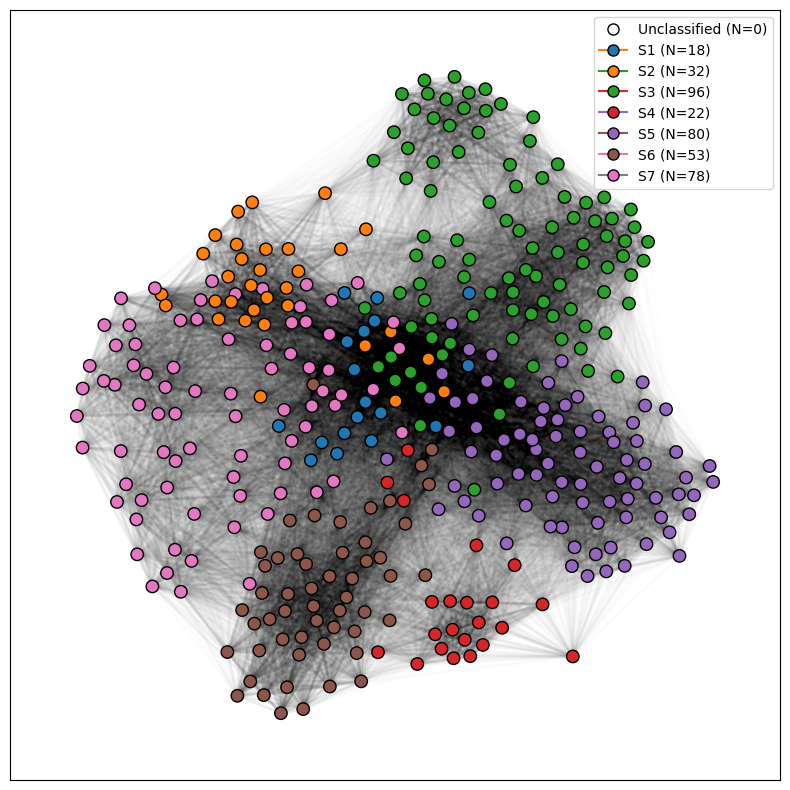

In [17]:
color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
pos = nx.spring_layout(G_population, seed=2, k=1 / np.sqrt(379) * 10, iterations=100)
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
edge_list = list(G_population.edges())
edge_alpha = [
        0.1 * G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0 else 0 for u, v in edge_list
    ]
nx.draw_networkx_edges(G_population, pos, alpha=edge_alpha, width=2)
nx.draw_networkx_nodes(
            G_population, pos, node_size=80, 
            node_color=[color_palette[int(i)] for i in Subgroup_ids], 
            edgecolors="black"
        )
handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[0],
        label=f"Unclassified (N={np.sum(Subgroup_ids == 0)})",
        markerfacecolor=color_palette[0],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
]
for i in range(1, len(np.unique(Subgroup_ids[Subgroup_ids!=0]))+1):
    patch = Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[i + 1],
        label=f"S{i} (N={np.sum(Subgroup_ids == i)})",
        markerfacecolor=color_palette[i],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
    handles.append(patch)
ax.legend(handles=handles)
plt.show()

### Plot hazard

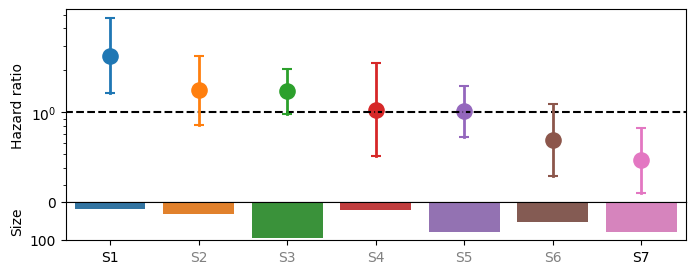

In [18]:
# Plot hazard ratio
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids_ == subgroup_id))
    xticklabels.append("S{}".format(int(subgroup_id)))
    if p < 0.05/len(HR):
        xtickcolors.append("k")
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

### Plot K-M survival curves

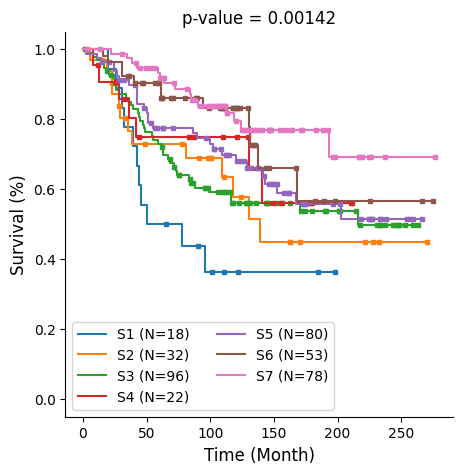

In [19]:
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    length_A, event_observed_A = (
            Length_[Subgroup_ids_ == subgroup_id],
            Status_[Subgroup_ids_ == subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], np.sum(Subgroup_ids_ == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})
log_rank_test  = multivariate_logrank_test(
        Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
    )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

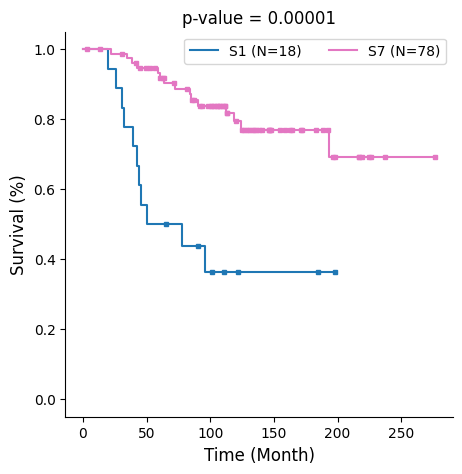

In [21]:
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
length_A, event_observed_A = (
            Length_[Subgroup_ids_ == 1],
            Status_[Subgroup_ids_ == 1],
        )
label = "S1 (N={})".format(np.sum(Subgroup_ids_ == 1))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[0],
show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})
length_B, event_observed_B = (
            Length_[Subgroup_ids_ == 7],
            Status_[Subgroup_ids_ == 7],
        )
label = "S7 (N={})".format( np.sum(Subgroup_ids_ == 7))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[6],
show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})


log_rank_test  = logrank_test(
    length_A, length_B, event_observed_A, event_observed_B
    
)
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

### Individual K-M plot for eaach subgroup

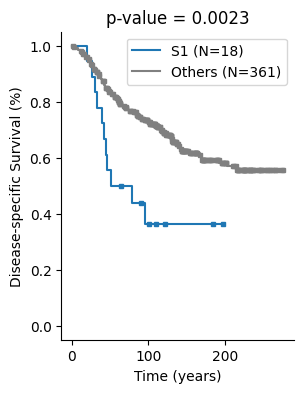

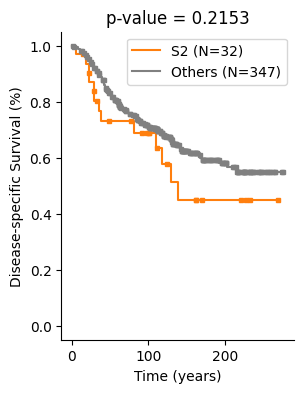

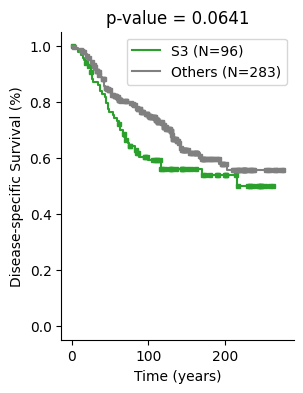

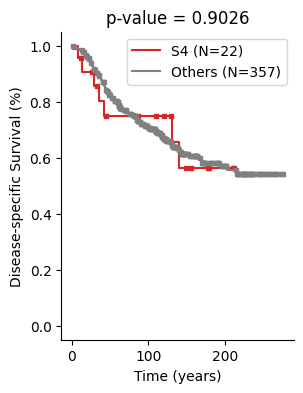

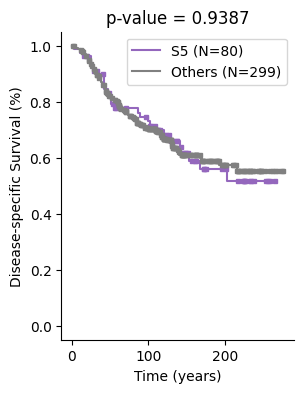

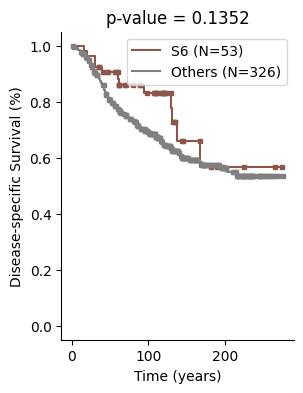

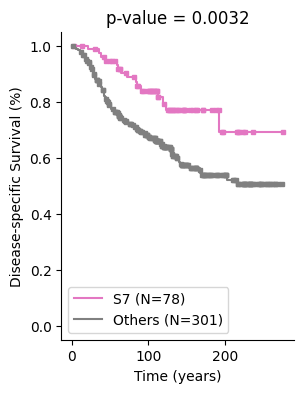

In [22]:
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    f, ax = plt.subplots(figsize=(3, 4))
    length_A, event_observed_A = (
            Length_[Subgroup_ids_ == subgroup_id],
            Status_[Subgroup_ids_ == subgroup_id],
        )
    length_B, event_observed_B = (
            Length_[Subgroup_ids_ != subgroup_id],
            Status_[Subgroup_ids_ != subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], len(length_A))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True, censor_styles={"ms": 3, "marker": "s"})
    label = "Others (N={})".format(len(length_B))
    kmf.fit(length_B, event_observed_B, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color="grey",
    show_censors=True, censor_styles={"ms": 3, "marker": "s"})
    log_rank_test = logrank_test(length_A, length_B, event_observed_A, event_observed_B)
    p_value = log_rank_test.p_value
    ax.legend()
    ax.set(
            title="p-value = {:.4f}".format(p_value),
            # title="Survival of {} vs. Others".format(hr_dict["subgroup_id"]),
            xlabel="Time (years)",
            ylabel=survival_type+" Survival (%)",
            ylim=(-0.05, 1.05),
        )
    sns.despine()
    plt.show()